In [ ]:
#| default_exp tycho2_processing

# Processing results

import dependencies

In [ ]:
from asterisms_py.tycho2_main import *
import polars as pl
import time
import math
import torch
import sys
sys.path.insert(0, '../star-charts')
from star_data import StarData, StarDataList
from input_file import InputFile
from diagram import Diagram
from coord_calc import CoordCalc
from skyfield.api import position_of_radec, load_constellation_map, load_constellation_names
from skyfield.units import Angle


Load the condensed Tycho2 star catalog we prepared earlier

In [ ]:
dftycho = pl.read_parquet('../support/tyc2-3.parquet')

In [ ]:
result_filename = '../result_triangle2.parquet'
df = pl.read_parquet(result_filename)
print("length of parquet results:", len(df))

length of parquet results: 14381


# Enrich data with constellation

In [ ]:
constellation_at = load_constellation_map()
con_full_names = dict(load_constellation_names())
con_full_names['CVn'] = 'Canes Venatici'


def get_mean(value):
    points = torch.tensor(value.to_list())
    mean = points.mean(dim=0)
    return points, mean

def get_center(value):
    _, mean = get_mean(value)
    dec = mean[1]
    ra = Angle(degrees=mean[0].item())
    return position_of_radec(ra._hours, dec)

def process_stars(value):
    center = get_center(value)
    return constellation_at(center)

def process_ra_h(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra._hours

def process_ra(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra.degrees
    
def process_dec_h(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[1].item())
    return ra.degrees
    
def process_ra_h_full(value):
    points, mean = get_mean(value)
    ra = Angle(degrees=mean[0].item())
    return ra.hstr(places=4, warn=False)

def process_dec_h_full(value):
    points, mean = get_mean(value)
    dec = Angle(degrees=mean[1].item())
    return dec.dstr(places=4, warn=False)
    
def full_names(short_name):
    return con_full_names[short_name]

def enrich_results(head):
    # Add a new column to the DataFrame
    head = head.with_columns(
        pl.col("stars").map_elements(process_ra, return_dtype=pl.Float64).alias("Ra")
    )
    head = head.with_columns(
        pl.col("stars").map_elements(process_ra_h, return_dtype=pl.Float64).alias("Rah")
    )
    # Add a new column to the DataFrame
    head = head.with_columns(
        pl.col("stars").map_elements(process_dec_h, return_dtype=pl.Float64).alias("Dec")
    )
    head = head.with_columns(
        pl.col("stars").map_elements(process_ra_h_full, return_dtype=pl.Utf8).alias("Rah_full")
    )
    head = head.with_columns(
        pl.col("stars").map_elements(process_dec_h_full, return_dtype=pl.Utf8).alias("Dec_full")
    )
    # Add a new column to the DataFrame
    head = head.with_columns(
        pl.col("stars").map_elements(process_stars, return_dtype=pl.Utf8).alias("CON")
    )
    head = head.with_columns(
        pl.col("CON").map_dict(con_full_names).alias("CONSTELLATION")
    )
    return head
    
head = df.sort("score").head(10)
enriched_results = enrich_results(head)
print(enriched_results.describe())
print(enriched_results)

shape: (9, 11)
┌────────────┬──────────┬────────────┬───────┬───┬──────────┬────────────┬──────┬───────────────┐
│ describe   ┆ score    ┆ region     ┆ stars ┆ … ┆ Rah_full ┆ Dec_full   ┆ CON  ┆ CONSTELLATION │
│ ---        ┆ ---      ┆ ---        ┆ ---   ┆   ┆ ---      ┆ ---        ┆ ---  ┆ ---           │
│ str        ┆ f64      ┆ f64        ┆ str   ┆   ┆ str      ┆ str        ┆ str  ┆ str           │
╞════════════╪══════════╪════════════╪═══════╪═══╪══════════╪════════════╪══════╪═══════════════╡
│ count      ┆ 10.0     ┆ 10.0       ┆ 10    ┆ … ┆ 10       ┆ 10         ┆ 10   ┆ 10            │
│ null_count ┆ 0.0      ┆ 0.0        ┆ 0     ┆ … ┆ 0        ┆ 0          ┆ 0    ┆ 0             │
│ mean       ┆ 0.000116 ┆ 1305.2     ┆ null  ┆ … ┆ null     ┆ null       ┆ null ┆ null          │
│ std        ┆ 0.000048 ┆ 824.634168 ┆ null  ┆ … ┆ null     ┆ null       ┆ null ┆ null          │
│ min        ┆ 0.000034 ┆ 120.0      ┆ null  ┆ … ┆ 00h 52m  ┆ -05deg 16' ┆ Aql  ┆ Aquila        │
│    

define focusstars

In [ ]:
from skyfield.units import Angle

def get_center_stars(result_entry):
    focusstars = result_entry['stars']
    return focusstars

define region stars

In [ ]:
def get_around_center_stars(result_entry, radius=3, limiting_mag=15):
    center = (result_entry['Ra'], result_entry['Dec'])
    region_stars = stars_for_center_and_radius(dftycho, center, radius, limiting_mag)
    return region_stars

In [ ]:
# def get_radec_minmax(region_stars):
#     ramin = region_stars['RAmdeg'].min()
#     ramax = region_stars['RAmdeg'].max()
#     demin = region_stars['DEmdeg'].min()
#     demax = region_stars['DEmdeg'].max()
#     return ramin,ramax,demin, demax

Processing entry: {'score': 3.4234322811244056e-05, 'region': 120, 'stars': [[12.699203491210938, 33.3016242980957, 9.212599754333496], [13.816502571105957, 33.352256774902344, 9.186579704284668], [13.227314949035645, 34.207252502441406, 9.603290557861328]], 'Ra': 13.247673034667969, 'Rah': 0.8831782023111978, 'Dec': 33.62038040161133, 'Rah_full': '00h 52m 59.4415s', 'Dec_full': '33deg 37\' 13.3694"', 'CON': 'Psc', 'CONSTELLATION': 'Pisces'}
Data frames look good, drawing the chart...
looking at Star(ra=13.247673034667969, dec=33.62038040161133, epoch=2451545.0)
Saving to region_120.png


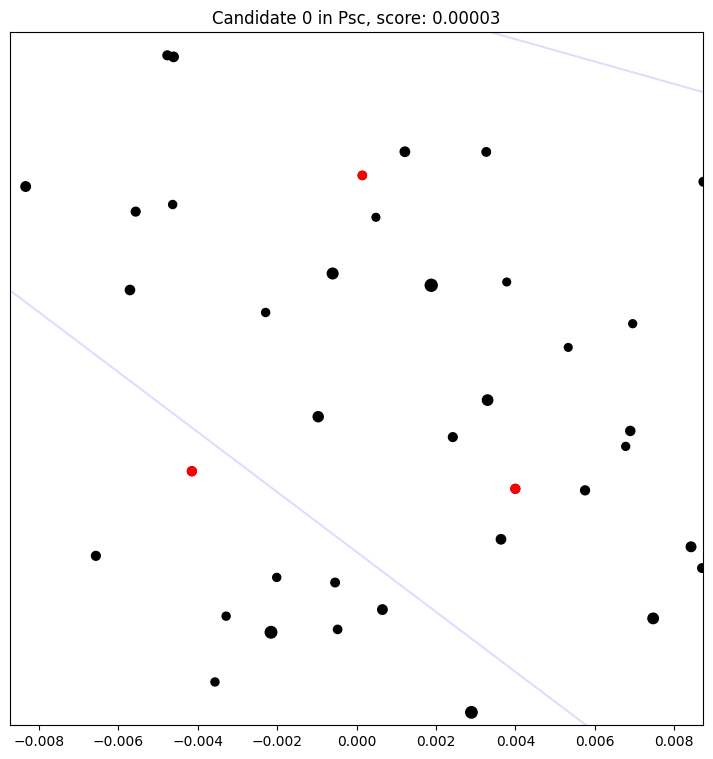

-----------------------------------------------------
Processing entry: {'score': 5.604226316791028e-05, 'region': 690, 'stars': [[85.19314575195312, 9.265445709228516, 7.951480388641357], [85.93985748291016, 9.914565086364746, 8.910310745239258], [84.56526184082031, 9.898636817932129, 9.001529693603516]], 'Ra': 85.23274993896484, 'Rah': 5.682183329264323, 'Dec': 9.692882537841797, 'Rah_full': '05h 40m 55.8600s', 'Dec_full': '09deg 41\' 34.3771"', 'CON': 'Ori', 'CONSTELLATION': 'Orion'}
Data frames look good, drawing the chart...
looking at Star(ra=85.23274993896484, dec=9.692882537841797, epoch=2451545.0)
Saving to region_690.png


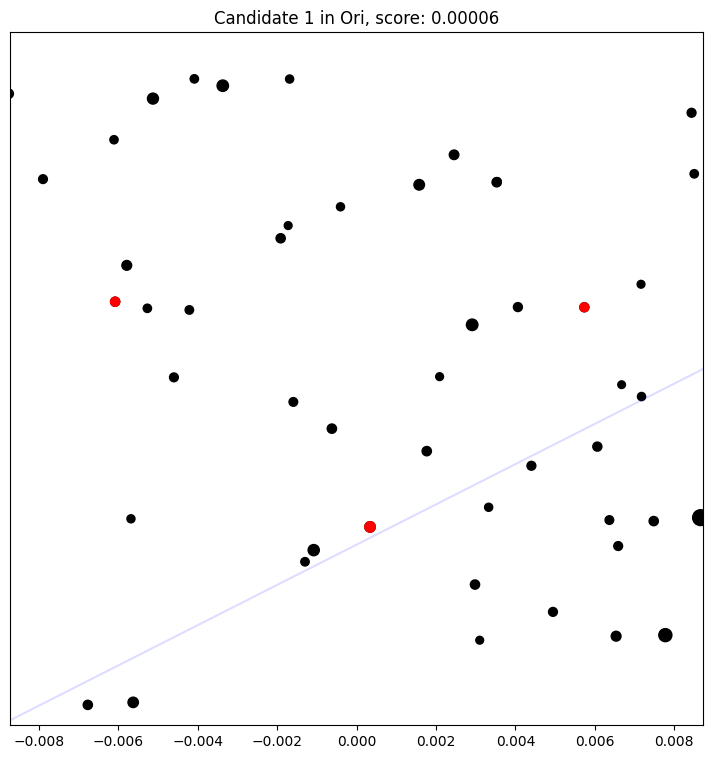

-----------------------------------------------------
Processing entry: {'score': 8.279387839138508e-05, 'region': 936, 'stars': [[117.87763977050781, -29.53165626525879, 9.915629386901855], [116.01558685302734, -30.50822639465332, 9.782360076904297], [117.35050964355469, -30.558074951171875, 8.152640342712402]], 'Ra': 117.08123779296875, 'Rah': 7.8054158528645825, 'Dec': -30.19931983947754, 'Rah_full': '07h 48m 19.4971s', 'Dec_full': '-30deg 11\' 57.5514"', 'CON': 'Pup', 'CONSTELLATION': 'Puppis'}
Data frames look good, drawing the chart...
looking at Star(ra=117.08123779296872, dec=-30.19931983947754, epoch=2451545.0)
Saving to region_936.png


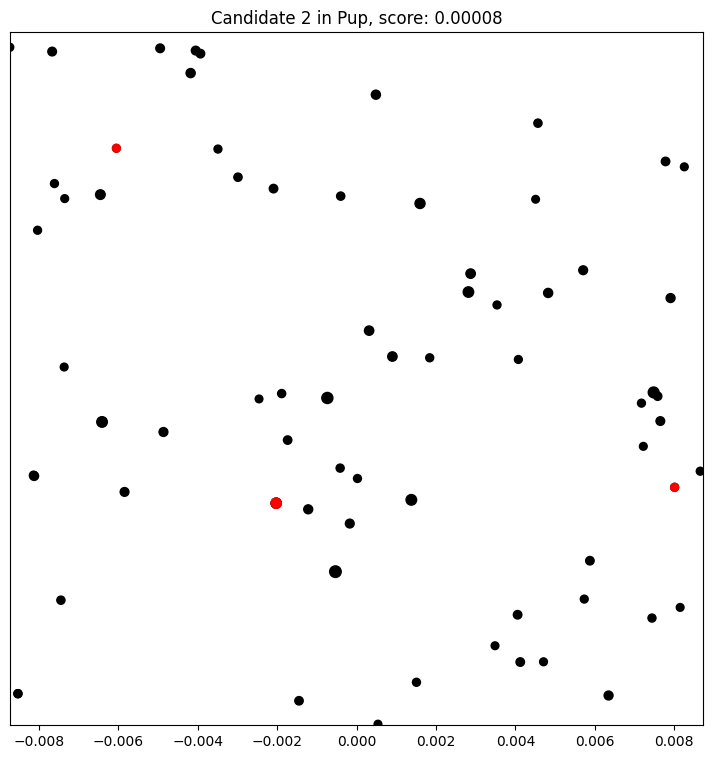

-----------------------------------------------------
Processing entry: {'score': 9.697688074083999e-05, 'region': 2124, 'stars': [[264.1142578125, -13.771879196166992, 9.10359001159668], [265.6324768066406, -13.294498443603516, 9.872389793395996], [265.3954162597656, -14.965069770812988, 9.3471097946167]], 'Ra': 265.04736328125, 'Rah': 17.66982421875, 'Dec': -14.010482788085938, 'Rah_full': '17h 40m 11.3672s', 'Dec_full': '-14deg 00\' 37.7380"', 'CON': 'Ser', 'CONSTELLATION': 'Serpens'}
Data frames look good, drawing the chart...
looking at Star(ra=265.04736328125, dec=-14.010482788085938, epoch=2451545.0)
Saving to region_2124.png


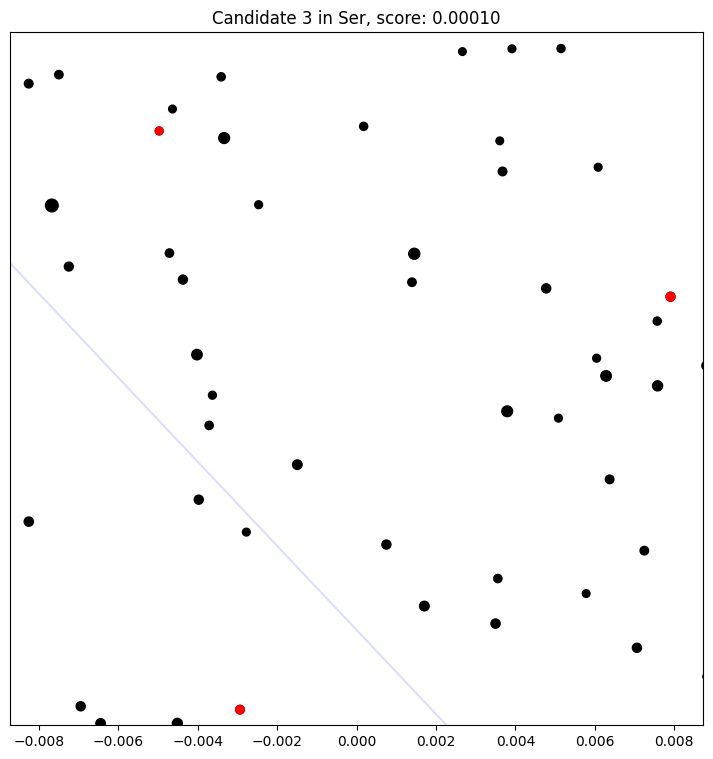

-----------------------------------------------------
Processing entry: {'score': 0.00010920267959591001, 'region': 2446, 'stars': [[305.1690368652344, -5.153712272644043, 9.31074047088623], [305.3651428222656, -5.580112934112549, 9.922849655151367], [305.8657531738281, -5.070743083953857, 9.631070137023926]], 'Ra': 305.4666442871094, 'Rah': 20.364442952473958, 'Dec': -5.268189907073975, 'Rah_full': '20h 21m 51.9946s', 'Dec_full': '-05deg 16\' 05.4837"', 'CON': 'Aql', 'CONSTELLATION': 'Aquila'}
Data frames look good, drawing the chart...
looking at Star(ra=305.4666442871094, dec=-5.268189907073975, epoch=2451545.0)
Saving to region_2446.png


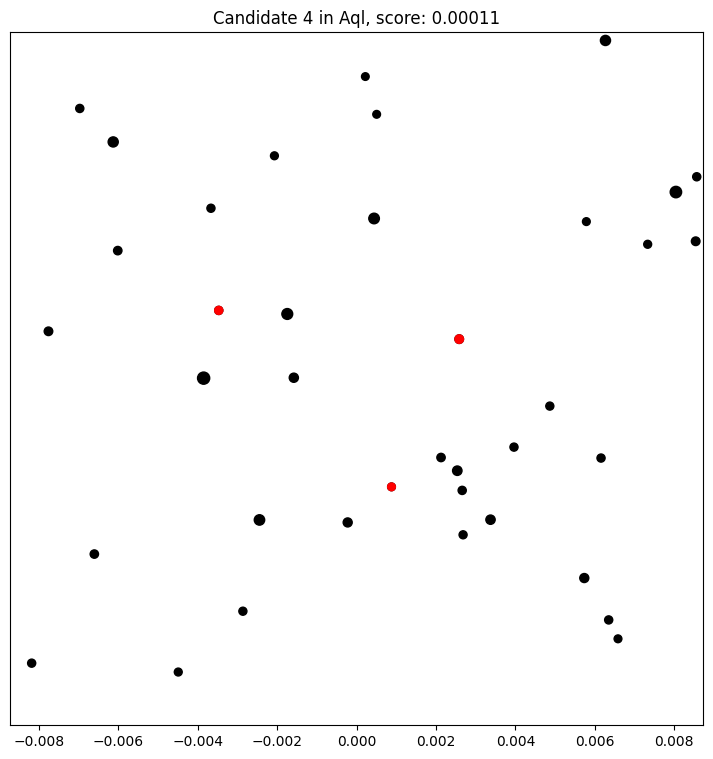

-----------------------------------------------------
Processing entry: {'score': 0.00015012340736575425, 'region': 526, 'stars': [[64.66145324707031, -6.23291015625, 9.575139999389648], [64.43769073486328, -5.146606922149658, 8.925189971923828], [65.64512634277344, -5.501140594482422, 9.189169883728027]], 'Ra': 64.91475677490234, 'Rah': 4.327650451660156, 'Dec': -5.626885890960693, 'Rah_full': '04h 19m 39.5416s', 'Dec_full': '-05deg 37\' 36.7892"', 'CON': 'Eri', 'CONSTELLATION': 'Eridanus'}
Data frames look good, drawing the chart...
looking at Star(ra=64.91475677490234, dec=-5.626885890960693, epoch=2451545.0)
Saving to region_526.png


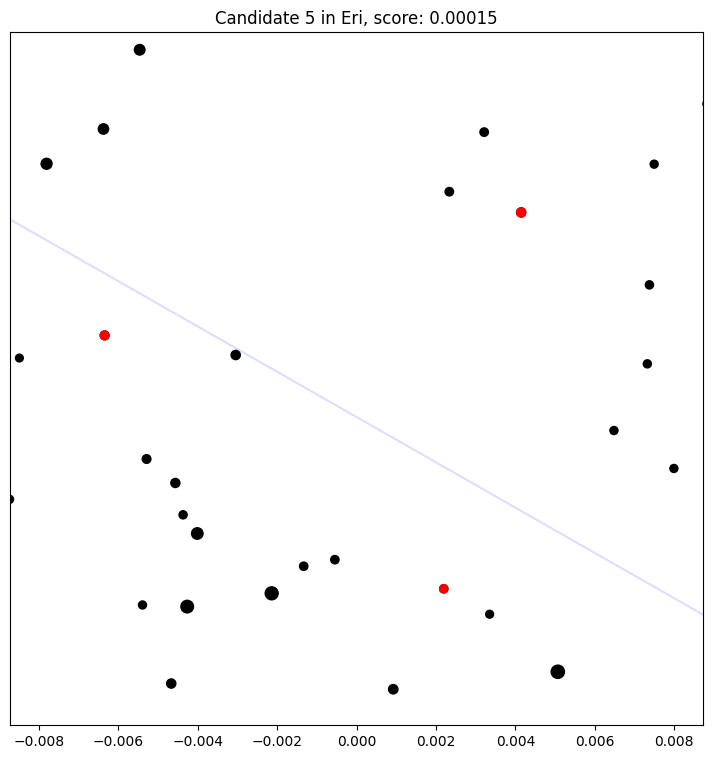

-----------------------------------------------------
Processing entry: {'score': 0.00015029327187221497, 'region': 2216, 'stars': [[277.2993469238281, -29.348346710205078, 8.151800155639648], [276.31781005859375, -30.928680419921875, 8.565629959106445], [277.888671875, -30.49534797668457, 9.555140495300293]], 'Ra': 277.1686096191406, 'Rah': 18.47790730794271, 'Dec': -30.25745964050293, 'Rah_full': '18h 28m 40.4663s', 'Dec_full': '-30deg 15\' 26.8547"', 'CON': 'Sgr', 'CONSTELLATION': 'Sagittarius'}
Data frames look good, drawing the chart...
looking at Star(ra=277.1686096191407, dec=-30.25745964050293, epoch=2451545.0)
Saving to region_2216.png


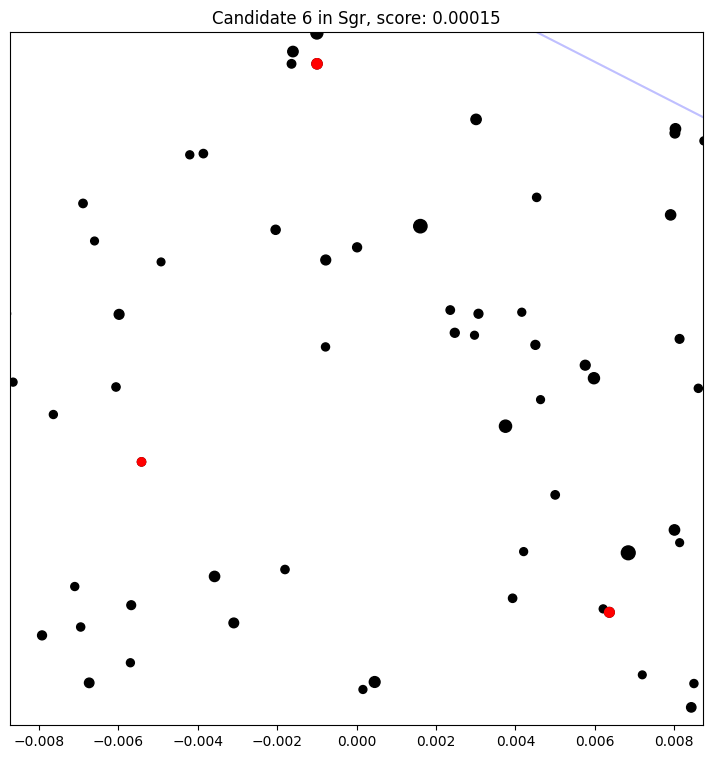

-----------------------------------------------------
Processing entry: {'score': 0.0001557648356538266, 'region': 912, 'stars': [[112.44180297851562, 2.753425121307373, 9.831709861755371], [113.02964782714844, 1.7645448446273804, 9.743880271911621], [113.57038116455078, 2.7720680236816406, 9.593280792236328]], 'Ra': 113.01394653320312, 'Rah': 7.534263102213542, 'Dec': 2.4300127029418945, 'Rah_full': '07h 32m 03.3472s', 'Dec_full': '02deg 25\' 48.0457"', 'CON': 'CMi', 'CONSTELLATION': 'Canis Minor'}
Data frames look good, drawing the chart...
looking at Star(ra=113.01394653320312, dec=2.4300127029418945, epoch=2451545.0)
Saving to region_912.png


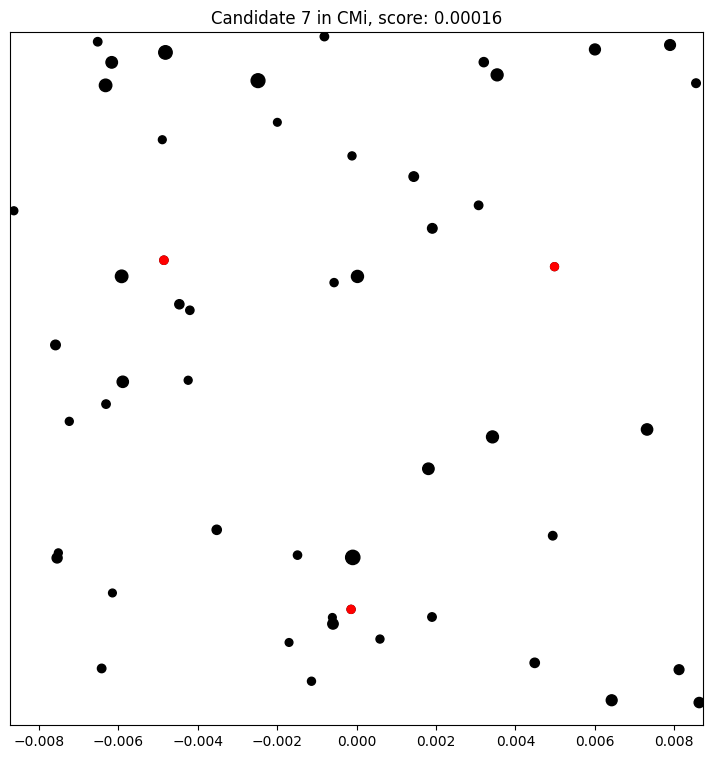

-----------------------------------------------------
Processing entry: {'score': 0.000156007066834718, 'region': 2054, 'stars': [[256.75616455078125, -38.907325744628906, 9.965270042419434], [257.11114501953125, -37.562015533447266, 9.206990242004395], [256.02801513671875, -38.549774169921875, 8.604379653930664]], 'Ra': 256.63177490234375, 'Rah': 17.108784993489586, 'Dec': -38.33970642089844, 'Rah_full': '17h 06m 31.6260s', 'Dec_full': '-38deg 20\' 22.9431"', 'CON': 'Sco', 'CONSTELLATION': 'Scorpius'}
Data frames look good, drawing the chart...
looking at Star(ra=256.63177490234375, dec=-38.33970642089844, epoch=2451545.0)
Saving to region_2054.png


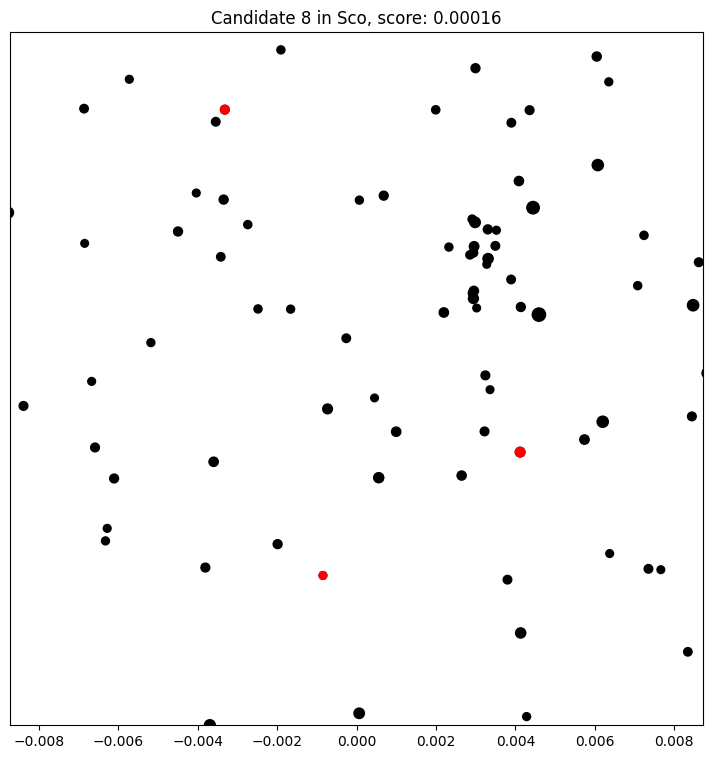

-----------------------------------------------------
Processing entry: {'score': 0.0001731268857838586, 'region': 1028, 'stars': [[129.06423950195312, -46.675045013427734, 9.412050247192383], [128.78089904785156, -45.22905731201172, 9.425819396972656], [129.656982421875, -45.79848861694336, 8.385930061340332]], 'Ra': 129.16737365722656, 'Rah': 8.611158243815103, 'Dec': -45.90086364746094, 'Rah_full': '08h 36m 40.1697s', 'Dec_full': '-45deg 54\' 03.1091"', 'CON': 'Vel', 'CONSTELLATION': 'Vela'}
Data frames look good, drawing the chart...
looking at Star(ra=129.16737365722653, dec=-45.90086364746094, epoch=2451545.0)
Saving to region_1028.png


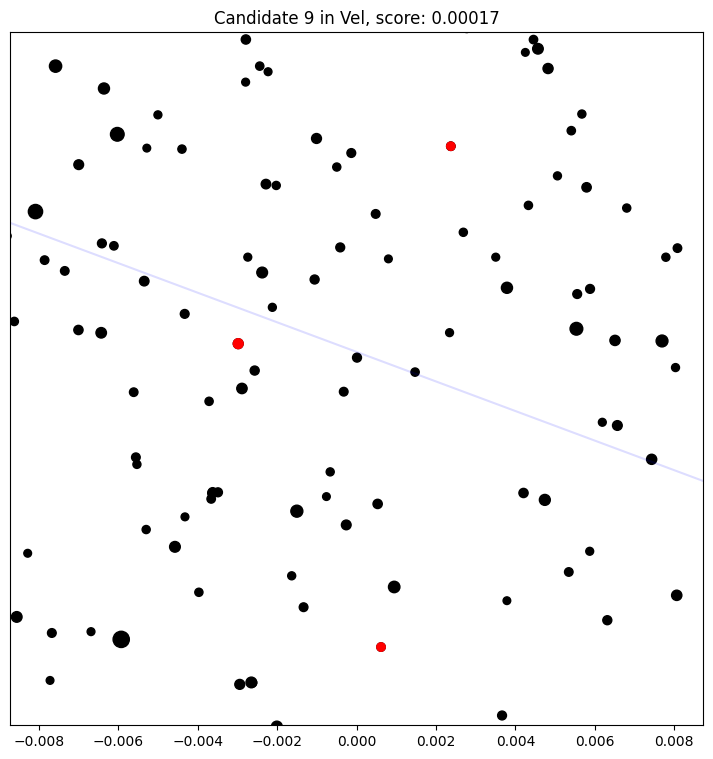

-----------------------------------------------------


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from skyfield.api import Star, load
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
import pandas

# Draw the stars.
def draw_points(ax, t, earth, projection, stars, limiting_magnitude, color):
    fs=pandas.DataFrame(stars, columns=['ra_hours', 'dec_degrees', 'magnitude'])
    fs['ra_hours'] = fs['ra_hours'] / 15
    fs['epoch_year']=2000
    star_positions = earth.at(t).observe(Star.from_dataframe(fs))
    fs['x'], fs['y'] = projection(star_positions)
    magnitude = fs['magnitude']
    marker_size2 = (0.5 + limiting_magnitude - magnitude) ** 2.0
    ax.scatter(fs['x'], fs['y'], s=marker_size2, color=color)
    
def draw_chart(chosen, region_stars, focus_stars, filename: str, title: str):
    # The comet is plotted on several dates `t_comet`.  But the stars only
    # need to be drawn once, so we take the middle comet date as the single
    # time `t` we use for everything else.
    
    ts = load.timescale()
    t = ts.utc(2023, 7, 27)
    
    # An ephemeris from the JPL provides Sun and Earth positions.
    
    eph = load('de421.bsp')
    sun = eph['sun']
    earth = eph['earth']
    looking_at = Star(ra_hours=chosen['Rah'],
                   dec_degrees=chosen['Dec'])
    print("looking at", looking_at)
    
    # The Minor Planet Center data file provides the comet orbit.
    
    # The Hipparcos mission provides our star catalog.
    
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)
    
    # And the constellation outlines come from Stellarium.  We make a list
    # of the stars at which each edge stars, and the star at which each edge
    # ends.
    
    url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
           '/skycultures/modern_st/constellationship.fab')
    
    with load.open(url) as f:
        constellations = stellarium.parse_constellations(f)
    
    edges = [edge for name, edges in constellations for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]
    
    # We will center the chart on the comet's middle position.
    
    center = earth.at(t).observe(looking_at)
    projection = build_stereographic_projection(center)
    field_of_view_degrees = 2.0
    limiting_magnitude = 15.0
    
    # Now that we have constructed our projection, compute the x and y
    # coordinates that each star and the comet will have on the plot.
    
    star_positions = earth.at(t).observe(Star.from_dataframe(stars))
    stars['x'], stars['y'] = projection(star_positions)
    
    # Create a True/False mask marking the stars bright enough to be
    # included in our plot.  And go ahead and compute how large their
    # markers will be on the plot.
    
    bright_stars = (stars.magnitude <= limiting_magnitude)
    magnitude = stars['magnitude'][bright_stars]
    marker_size = (0.5 + limiting_magnitude - magnitude) ** 2.0
    
    # The constellation lines will each begin at the x,y of one star and end
    # at the x,y of another.  We have to "rollaxis" the resulting coordinate
    # array into the shape that matplotlib expects.
    
    xy1 = stars[['x', 'y']].loc[edges_star1].values
    xy2 = stars[['x', 'y']].loc[edges_star2].values
    lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)
    
    # Time to build the figure!
    
    fig, ax = plt.subplots(figsize=[9, 9])
    
    # Draw the constellation lines.
    
    ax.add_collection(LineCollection(lines_xy, colors='#00f2'))
    
    draw_points(ax, t, earth, projection, region_stars.rows(), limiting_magnitude, 'k')
    draw_points(ax, t, earth, projection, focus_stars, limiting_magnitude, 'r')
        
    # Finally, title the plot and set some final parameters.
    
    angle = np.pi - field_of_view_degrees / 360.0 * np.pi
    limit = np.sin(angle) / (1.0 - np.cos(angle))
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    #plt.xticks(region_stars['x'], pretty_numbers)
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(False)
    ax.set_aspect(1.0)
    ax.set_title(title)
    
    # Save.
    print(f"Saving to {filename}")
    fig.savefig(filename, bbox_inches='tight')
    plt.show()
    plt.close(fig)

for idx, entry in enumerate(enriched_results.iter_rows(named=True)):
    try:
        print(f"Processing entry: {entry}")
        
        focus_stars = get_center_stars(entry)
        region_stars = get_around_center_stars(entry, limiting_mag=10)

        # Check if the data frames are empty
        if len(focus_stars) == 0 or len(region_stars) == 0:
            print(f"Skipping due to empty data frames for entry: {entry}")
            continue

        print("Data frames look good, drawing the chart...")
        
        draw_chart(entry, region_stars, focus_stars, f"region_{entry['region']}.png", f"Candidate {idx} in {entry['CON']}, score: {entry['score']:.5f}")
        
        print("-----------------------------------------------------")
        
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
print(type(region_stars))

<class 'polars.dataframe.frame.DataFrame'>
